# Homework 3
Section 8.3

Math 404

Winter 2020

Logan Schelly

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Re-run all the stuff fom last lab.
class LinearModel(object):
    
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.transition_model = F
        self.state_noise_covariance = Q
        self.observation_model = H
        self.observation_noise_covariance = R
        self.control_vector = u
        return
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the linear system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        """
        #Unpack the variables.
        F = self.transition_model
        H = self.observation_model
        Q = self.state_noise_covariance
        R = self.observation_noise_covariance
        u = self.control_vector
        
        #Initialize space for states and observations.
        m, n = H.shape
        X = np.empty((n, N)) #states
        Y = np.empty((m, N)) #obs
        
        #Store the original state and observation.
        X[:, 0] = x0
        v0 = np.random.multivariate_normal(np.zeros(m), R) #observation noise
        Y[:, 0] = H.dot(x0) + v0
        
        #Iteratively calculate susequent states and observations
        for k in range(1,N):
            #Find the state noise.
            w = np.random.multivariate_normal(np.zeros(n), Q)
            #Update state with equation 8.10a
            X[:,k] = F.dot(X[:,k-1]) + u + w #G is I.
            #Find observation noise
            v = np.random.multivariate_normal(np.zeros(m), R)
            #Create next observation with equation 8.10b
            Y[:,k] = H.dot(X[:,k]) + v
        
        return X, Y #X is states, Y is obs
    
dt = 0.1#seconds
Q = 0.1 * np.eye(4)
R = 5000 * np.eye(2)
x0 = np.array([0, 0, 300, 600])
g= -9.8

#Construct F.
F = np.eye(4)
#Set the up 2 off-diagonal to dt
F[np.r_[:2], 2+np.r_[:2]] = dt

#Construct u.
u = np.zeros(4)
u[-1] = g*dt

#Construct H
H = np.zeros((2, 4))
np.fill_diagonal(H, 1)

#1250 time steps.
N = 1250

#Make the linear model and evolve it.
lm = LinearModel(F, Q, H, R, u)
X, Y = lm.evolve(x0, N)

## Exercise 8.10
Add a method ``estimate`` to your ``LinearModel`` class to use the Kalman filter
to estimate a state sequence corresponding to a given observation sequence
``y`` and initial state estimate ``x0``. Your method should have this basic form:

In [3]:
#%%capture
#Don't print out from this cell with %%capture
#Run the previous notebook, so we can start off where we left off.
#%run hw82.ipynb <- Don't do this.  Cory wants you to copy/paste

class LinearModel(LinearModel):
    def estimate(self,x0,P,y):
        """
        Compute the state estimates using the Kalman filter.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        y : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        F = self.transition_model
        #G=I is trivial
        u = self.control_vector
        Q = self.state_noise_covariance
        H = self.observation_model
        R = self.observation_noise_covariance
        
        N = y.shape[1]
        x = np.empty((x0.size, N))
        x_prev = x0
        
        for k, yk in enumerate(y.T):
            #predict
            xp = F.dot(x_prev) + u
            Pp = F.dot(P.dot(F.T)) + Q
            #update
            P = np.linalg.inv(
                    np.linalg.inv(Pp) 
                    + H.T.dot(np.linalg.solve(R, H))
            )
            x[:,k] = xp - P.dot(H.T.dot(np.linalg.solve(R, H.dot(xp)-yk)))

            x_prev = x[:,k]
        
        return x

## Exercise 8.11
Returning to the projectile example, assume that the radar sensor has taken observations from time steps 200 through 800 (Take the corresponding slice of the observations produced in Exercise 8.8).

In [4]:
#Code for taking the slice goes here.
Y_slice = Y[:,200:801]
X_slice = X[:,200:801]

Use these observations to estimate the corresponding true states of the projectile at those times.

### Part (i)
Construct an estimate $\widehat{\mathbf{x}}_{200}$ as follows: For the horizontal and vertical positions, simply use the observed position at time 200.  For the velocity, compute the average velocity between the observations $\mathbf{y}_k$ and $\mathbf{y}_{k+1}$ for $k = 200, \ldots, 208$, then average these 9 values and take this as the initial velocity estimate.

In [5]:
n_obs = Y_slice.shape[1]
x_hat = np.empty((4, n_obs))
x_hat[:2,0] = Y_slice[:,0]

avg_velocities = np.diff(
    Y_slice[:,:9],
    axis=1,
    append=Y_slice[:,[9]]
)/dt
x_hat[2:,0] = avg_velocities.mean(axis=1)

### Part (ii)
Use the initial accuracy estimate $P_{200} = 10^6 \cdot Q$ and feed $P_{200}$, $\widehat{\mathbf{x}}_{200}$, and $\mathbf{y}_{201}, \ldots, \mathbf{y}_{800}$ into the Kalman filter to obtain estimates $\widehat{\mathbf{x}}_{201}, \ldots, \widehat{\mathbf{x}}_{800}$.

In [6]:
P200 = 10**6 * Q
#Make a new linear model, so it will have the estimate method.
lm = LinearModel(lm.transition_model,
        lm.state_noise_covariance,
        lm.observation_model,
        lm.observation_noise_covariance,
        lm.control_vector)
#Do the estimation
x_hat[:,1:] = lm.estimate(x_hat[:,0], P200, Y_slice[:,1:])

### Part (iii)
Plot these state estimates as a smooth green curve together with the radar observations (as red dots) and the entrire true state sequence (as a blue curve).

Zoom in to see how well it follows the true path.  Your plots should be similar to Figure 8.3.

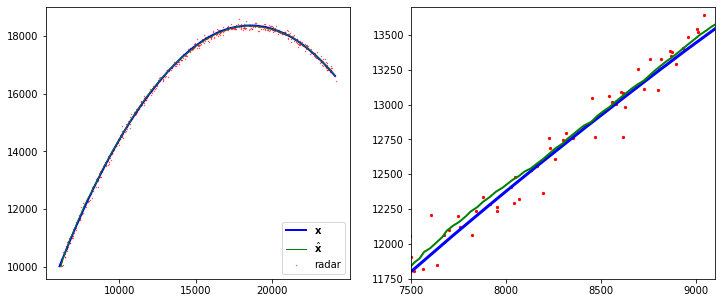

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1, ax2 = axes.ravel()

ax1.scatter(Y_slice[0], Y_slice[1], label='radar', color='red', s=.1)
ax1.plot(X_slice[0], X_slice[1], label=r'$\mathbf{x}$', color='blue', lw=2)
ax1.plot(x_hat[0], x_hat[1], label=r'$\hat{\mathbf{x}}$', color='green', lw=1)
ax1.set_xticks([10000, 15000, 20000])
ax1.legend(loc='lower right')

ax2.scatter(Y_slice[0], Y_slice[1], color='red', s=5)
ax2.plot(X_slice[0], X_slice[1], color='blue', lw=3)
ax2.plot(x_hat[0], x_hat[1], color='green', lw=2)
ax2.set_xlim([7500, 9100])
ax2.set_xticks([7500, 8000, 8500, 9000])
ax2.set_ylim([11750, 13700])

plt.show()